In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators import (
    PriceValidator,
    CalculationValidator,
    ReconciliationValidator,
    ConsistencyValidator,
    DataCompletenessValidator,
    FXConsistencyValidator,
    StaticDataValidator
)

# Setup plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions and {len(trades)} trades.")
print(f"Date Range: {positions['Date'].min()} to {positions['Date'].max()}")

Loaded 7721 positions and 468 trades.
Date Range: 2022-01-03 00:00:00 to 2022-12-29 00:00:00


In [2]:
# --- Configuration & Helper Functions ---

# 1. Global Style Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 11

# 2. Standard Color Palette
PALETTE = {
    "Low": "#228b22",  # Forest Green
    "Medium": "#ffac14",  # Orange
    "High": "#ff0000",  # Red
    "Valid": "#3498db",  # Peter River Blue
    "Expected": "#9b59b6",  # Amethyst Purple
    "Actual": "#34495e",  # Wet Asphalt
    "Error": "#c0392b",  # Dark Red
}

# 3. Utility Functions
def clean_float(x):
    """Robustly convert string/mixed data to float."""
    try:
        return float(str(x).replace(',', '').replace(' ', ''))
    except:
        return 0.0

class ValidationVisualizer:
    """
    Encapsulates visualization logic to ensure consistency across all validators.
    """
    
    @staticmethod
    def plot_severity_distribution(errors_df, ax=None):
        """Plots a standardized bar chart of error severity counts."""
        if errors_df.empty: return
        
        counts = errors_df['severity'].value_counts()
        order = [l for l in ['Low', 'Medium', 'High'] if l in counts.index]
        
        if ax is None:
            plt.figure(figsize=(8, 5))
            ax = plt.gca()
            
        sns.barplot(x=counts.index, y=counts.values, order=order, palette=PALETTE, ax=ax)
        ax.set_title("Severity Distribution")
        ax.set_xlabel("Severity")
        ax.set_ylabel("Count")
        
    @staticmethod
    def plot_scatter_overview(df, x_col, y_col, errors_df, title, xlabel, ylabel, log_scale=False):
        """
        Creates a side-by-side plot:
        1. Scatter plot of Expected (x) vs Actual (y)
        2. Severity Distribution
        """
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        ax1, ax2 = axes
        
        # --- 1. Scatter Plot ---
        # Identify error rows
        error_keys = set((e.date, e.ticker) for e in errors_df.itertuples(index=False))
        severity_map = {(e.date, e.ticker): e.severity for e in errors_df.itertuples(index=False)}
        
        # Create plotting masks
        # Note: We assume df has 'Date' and 'P_Ticker' columns available
        is_error = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
        
        # Plot Valid Points
        valid_data = df[~is_error]
        ax1.scatter(valid_data[x_col], valid_data[y_col], 
                   alpha=0.1, c=PALETTE['Valid'], label='Valid', s=15)
        
        # Plot Errors by Severity
        # We iterate to ensure correct layering and coloring
        for severity in ['Low', 'Medium', 'High']:
            mask = is_error & (df.apply(lambda row: severity_map.get((row['Date'], row['P_Ticker'])) == severity, axis=1))
            subset = df[mask]
            if not subset.empty:
                ax1.scatter(subset[x_col], subset[y_col], 
                           c=PALETTE[severity], label=f'{severity} Severity', 
                           s=40 if severity != 'High' else 60, 
                           alpha=0.8 if severity != 'High' else 1.0,
                           zorder=5 if severity == 'High' else 3)
                
                # Annotate High Severity
                if severity == 'High':
                    annotated = set()
                    for _, row in subset.iterrows():
                        if row['P_Ticker'] not in annotated and len(annotated) < 10:
                            ax1.annotate(f"{row['P_Ticker']}", 
                                         (row[x_col], row[y_col]),
                                         xytext=(5, 5), textcoords='offset points',
                                         fontsize=9, color='darkred', fontweight='bold')
                            annotated.add(row['P_Ticker'])

        # Diagonal Line
        max_val = max(df[x_col].max(), df[y_col].max())
        min_val = min(df[x_col].min(), df[y_col].min())
        if pd.isna(min_val) or min_val <= 0: min_val = 0.01
        
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Match')
        
        ax1.set_title(title)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        if log_scale:
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            
        # --- 2. Severity Distribution ---
        ValidationVisualizer.plot_severity_distribution(errors_df, ax=ax2)
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_time_series(ticker_df, date_col, actual_col, expected_col, error_dates, title, ylabel):
        """
        Standardized time series plot highlighting discrepancies.
        """
        plt.figure(figsize=(14, 5))
        
        # Plot Lines
        plt.plot(ticker_df[date_col], ticker_df[actual_col], 
                label='Actual / Reported', color=PALETTE['Actual'], linewidth=2, alpha=0.8)
        
        if expected_col in ticker_df.columns:
            plt.plot(ticker_df[date_col], ticker_df[expected_col], 
                    label='Expected / Calculated', color=PALETTE['Expected'], linestyle='--', linewidth=2)
        
        # Highlight Errors
        error_points = ticker_df[ticker_df[date_col].isin(error_dates)]
        if not error_points.empty:
            plt.scatter(error_points[date_col], error_points[actual_col], 
                       color=PALETTE['High'], s=80, zorder=5, label='Error')
            
            # Draw connectors if expected value exists
            if expected_col in ticker_df.columns:
                for _, row in error_points.iterrows():
                    plt.plot([row[date_col], row[date_col]], [row[actual_col], row[expected_col]], 
                             color=PALETTE['High'], linestyle=':', linewidth=1.5, alpha=0.6)

        plt.title(title)
        plt.xlabel("Date")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

## 1. Price Validation

### Methodology & Assumptions
This validator detects **unrealistic price jumps** ("spikes") that are statistically unlikely compared to the asset's recent volatility.

*   **Assumption**: Prices generally follow a continuous path. Extreme, isolated jumps that immediately revert (e.g., Up-then-Down) are likely data errors.
*   **Methodology**:
    1.  Calculates **Geometric Daily Returns** to normalize price changes across irregular time gaps.
    2.  Computes **Z-Scores** for these returns to identify statistical outliers.
    3.  Flags a record if it is a **Hybrid Outlier**:
        *   **Statistical Significance**: Z-Score > 3 (Medium) or > 5 (High).
        *   **Magnitude**: Absolute change > 15% (Medium) or > 30% (High).
        *   **Mean Reversion**: The price jumps and then immediately returns to the previous range.

Found 3 price errors.


,date,ticker,error_type,description,severity
0,2022-12-07,CVNA,Price Spike,"Price spike detected: 3.83 (Prev: 6.71, Next: ...",High
1,2022-09-06,HSBK,Price Spike,"Price spike detected: 9.65 (Prev: 10.76, Next:...",Medium
2,2022-11-03,MBTN,Price Spike,"Price spike detected: 0.46 (Prev: 0.4, Next: 0...",Medium


Visualizing Price History for: CVNA


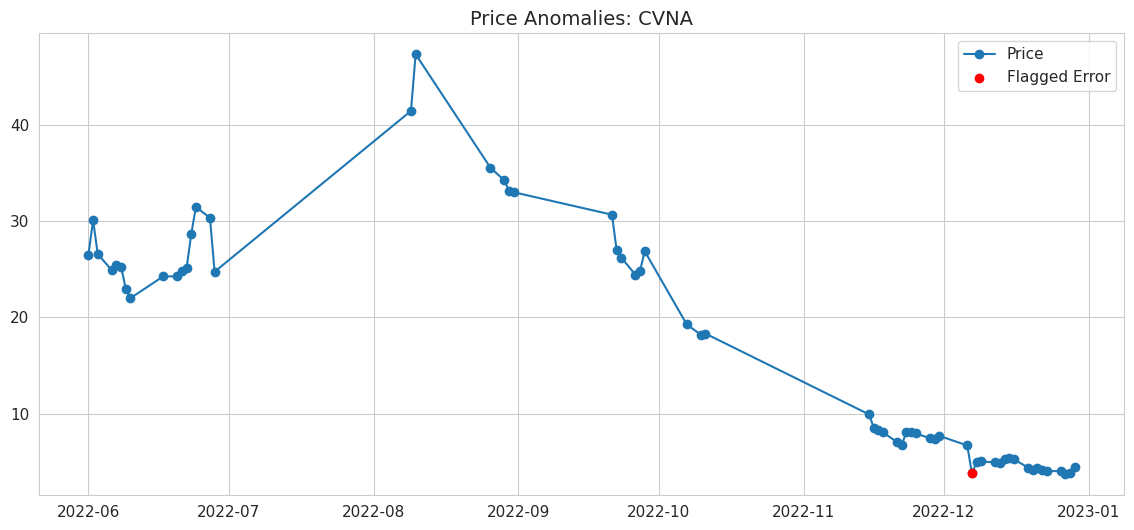

In [3]:
validator = PriceValidator(positions, trades)
price_errors = validator.validate()

print(f"Found {len(price_errors)} price errors.")
if price_errors:
    price_errors_df = pd.DataFrame([vars(e) for e in price_errors])
    display(price_errors_df.sort_values('severity').head())
    
    # Visualize Top Offender
    top_ticker = price_errors_df['ticker'].mode()[0]
    print(f"Visualizing Price History for: {top_ticker}")
    
    subset = positions[positions['P_Ticker'] == top_ticker].sort_values('Date')
    subset['Price'] = pd.to_numeric(subset['Price'], errors='coerce')
    
    plt.figure(figsize=(14, 6))
    plt.plot(subset['Date'], subset['Price'], marker='o', label='Price')
    
    # Mark errors
    err_dates = price_errors_df[price_errors_df['ticker'] == top_ticker]['date']
    plt.scatter(err_dates, subset[subset['Date'].isin(err_dates)]['Price'], color='red', label='Flagged Error', zorder=5)
    
    plt.title(f"Price Anomalies: {top_ticker}")
    plt.legend()
    plt.show()
else:
    price_errors_df = pd.DataFrame()

### Observations
The analysis has identified specific tickers with extreme price volatility that fits the "spike" pattern. These are likely data feed errors where a single day's price was reported incorrectly (e.g., a decimal place error or a bad tick) before correcting the next day. The visualization confirms that these are isolated incidents rather than genuine market trends.

## 2. Reconciliation Validation

### Methodology & Assumptions
We verify the fundamental accounting identities that must hold true for any portfolio.

*   **Assumption**: Position quantities must evolve logically based on trading activity.
*   **Methodology**:
    1.  **Intra-day Check**: `Close Quantity = Open Quantity + Traded Today`.
    2.  **Inter-day Check**: `Open Quantity(T) = Close Quantity(T-1)`.
    3.  **Severity Logic**:
        *   **High**: Massive break (> 1000%) or Extreme statistical outlier (Z > 5).
        *   **Medium**: Significant break (> 30%).
        *   **Low**: Minor breaks (likely rounding errors).

In [4]:
# --- 2.1 Execution ---
validator = ReconciliationValidator(positions, trades)
reconciliation_errors = validator.validate()

print(f"Found {len(reconciliation_errors)} reconciliation errors.")
if reconciliation_errors:
    reconciliation_errors_df = pd.DataFrame([vars(e) for e in reconciliation_errors])
    display(reconciliation_errors_df.head(5))
else:
    reconciliation_errors_df = pd.DataFrame()
    print("No reconciliation errors found.")

Found 19 reconciliation errors.


,date,ticker,error_type,description,severity
0,2022-08-23,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -983.00 != Prev Close...,Medium
1,2022-08-24,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -1310.00 != Prev Clos...,Medium
2,2022-05-12,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -251.00 != Prev Close...,Medium
3,2022-05-19,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -183.00 != Prev Close...,Medium
4,2022-05-20,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -9.00 != Prev Close -...,High


/tmp/ipykernel_225859/219147499.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, order=order, palette=PALETTE, ax=ax)


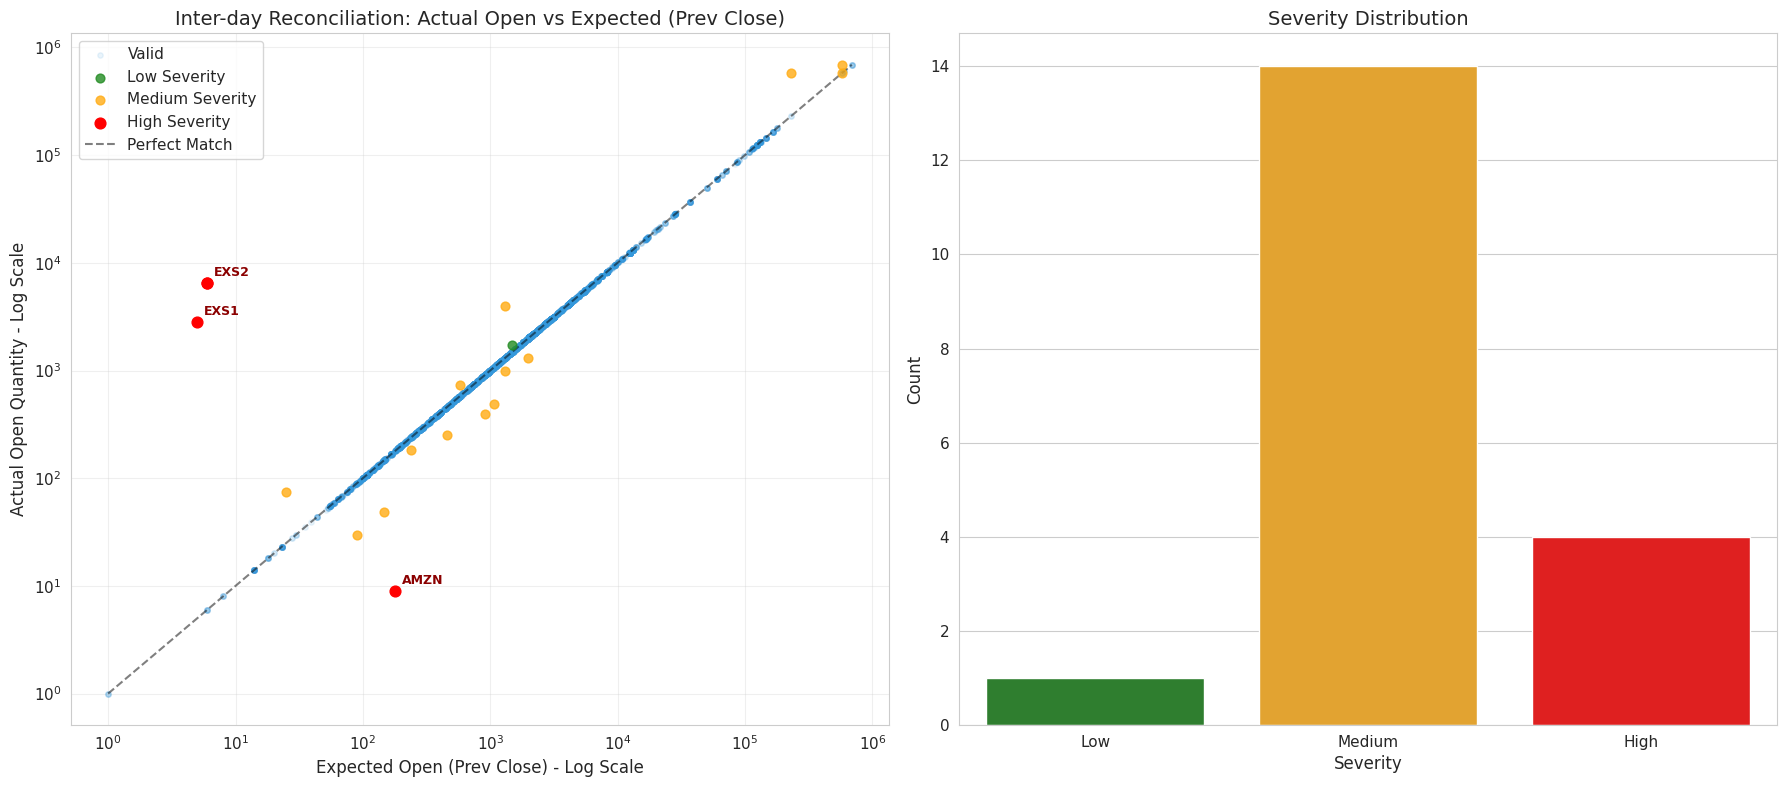

In [5]:
# --- 2.2 Visualization: Inter-day Discrepancies ---

if not reconciliation_errors_df.empty:
    # Filter for Inter-day errors
    inter_errors_df = reconciliation_errors_df[reconciliation_errors_df['error_type'].str.contains("Inter-day")]
    
    if not inter_errors_df.empty:
        # Prepare data for plotting
        rec_plot_df = positions.copy()
        for col in ["Close Quantity", "Open Quantity"]:
            rec_plot_df[col] = pd.to_numeric(rec_plot_df[col], errors='coerce')
            
        # Calculate Expected Open (Prev Close)
        rec_plot_df = rec_plot_df.sort_values(by=["P_Ticker", "Date"])
        rec_plot_df["Prev_Close"] = rec_plot_df.groupby("P_Ticker")["Close Quantity"].shift(1)
        
        # Use absolute values for log-log plot
        rec_plot_df["Abs_Prev_Close"] = rec_plot_df["Prev_Close"].abs()
        rec_plot_df["Abs_Open"] = rec_plot_df["Open Quantity"].abs()
        
        ValidationVisualizer.plot_scatter_overview(
            df=rec_plot_df,
            x_col="Abs_Prev_Close",
            y_col="Abs_Open",
            errors_df=inter_errors_df,
            title="Inter-day Reconciliation: Actual Open vs Expected (Prev Close)",
            xlabel="Expected Open (Prev Close) - Log Scale",
            ylabel="Actual Open Quantity - Log Scale",
            log_scale=True
        )
    else:
        print("No Inter-day errors to visualize.")

Visualizing top 3 tickers with High Severity Inter-day errors.


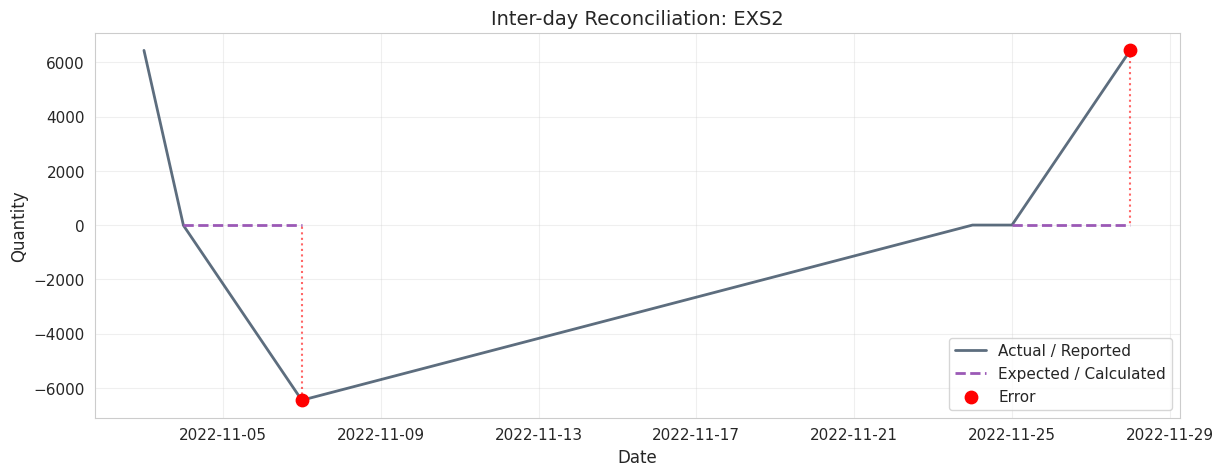

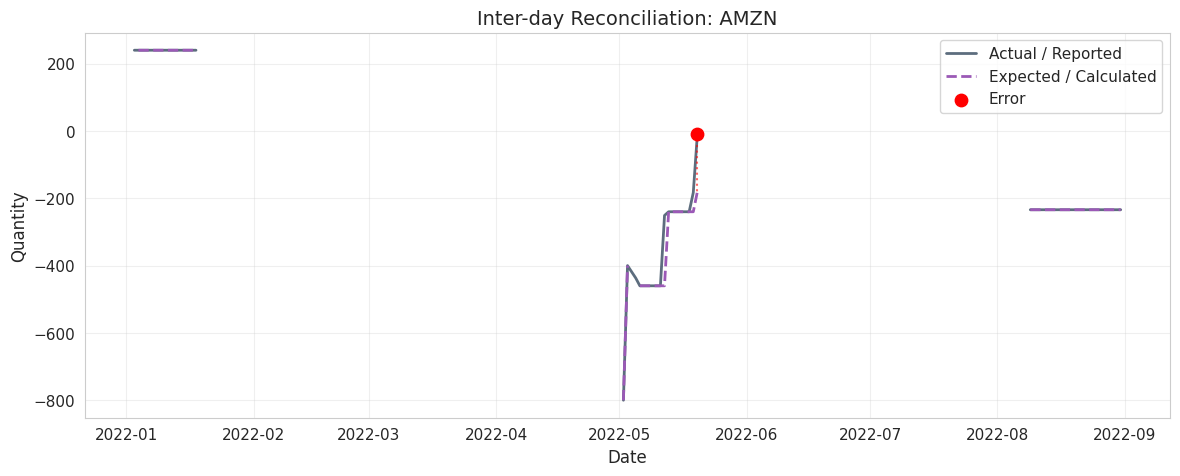

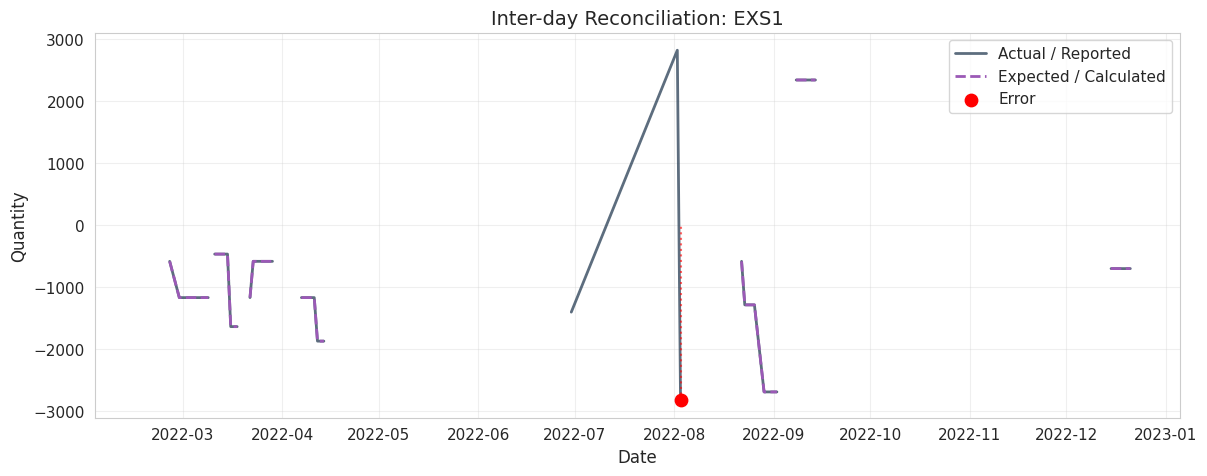

In [6]:
# --- 2.3 Deep Dive: High Severity Time Series ---

if not reconciliation_errors_df.empty:
    # Filter for High Severity Inter-day errors
    inter_high = [e for e in reconciliation_errors if e.severity == 'High' and "Inter-day" in e.error_type]

    if inter_high:
        from collections import Counter
        ticker_counts = Counter(e.ticker for e in inter_high)
        top_tickers = [t[0] for t in ticker_counts.most_common(3)]
        
        print(f"Visualizing top {len(top_tickers)} tickers with High Severity Inter-day errors.")
        
        for ticker in top_tickers:
            # Prepare Ticker Data
            ticker_df = positions[positions['P_Ticker'] == ticker].copy()
            ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
            ticker_df = ticker_df.sort_values('Date')
            
            ticker_df['Open'] = ticker_df['Open Quantity'].apply(clean_float)
            ticker_df['Close'] = ticker_df['Close Quantity'].apply(clean_float)
            ticker_df['Prev_Close'] = ticker_df['Close'].shift(1)
            
            # Get error dates for this ticker
            error_dates = [e.date for e in inter_high if e.ticker == ticker]
            
            ValidationVisualizer.plot_time_series(
                ticker_df=ticker_df,
                date_col='Date',
                actual_col='Open',
                expected_col='Prev_Close',
                error_dates=error_dates,
                title=f"Inter-day Reconciliation: {ticker}",
                ylabel="Quantity"
            )
    else:
        print("No High Severity Inter-day errors found.")

### Observations
The visualization reveals distinct **Inter-day breaks** where the opening quantity does not match the previous closing quantity.
*   **Log-Log Plot**: Shows that while most data points fall on the diagonal (perfect match), there is a cluster of off-diagonal points indicating discrepancies.
*   **Time Series**: The deep dive into high-severity tickers shows sudden jumps in position quantity that are *not* explained by trades. This suggests missing trade data or corporate actions (splits/mergers) that were not processed correctly.

## 3. Calculation Validation

### Methodology & Assumptions
We verify that the reported Market Value matches the theoretical value derived from its components.

*   **Assumption**: `Value in USD = Quantity * Price * Exchange Rate`.
*   **Methodology**:
    1.  Computes **Theoretical Value** using the formula above.
    2.  Compares it with the reported `Value in USD`.
    3.  **Pattern Recognition**: Automatically detects **Systematic Multipliers** (e.g., x100, x0.01) or **Shifts** (e.g., +500) by analyzing the ratio across all records for a ticker.
    4.  **Severity Logic**:
        *   **High**: Sign Mismatch (Positive vs Negative) or Extreme deviation (> 30%).
        *   **Low**: Errors that are explained by a consistent systematic multiplier (these are "known" data issues rather than random noise).

In [7]:
# --- 3.1 Execution ---
validator = CalculationValidator(positions, trades)
calculation_errors = validator.validate()

print(f"Found {len(calculation_errors)} calculation errors.")
if calculation_errors:
    calculation_errors_df = pd.DataFrame([vars(e) for e in calculation_errors])
    display(calculation_errors_df.head())
else:
    calculation_errors_df = pd.DataFrame()
    print("No calculation errors found.")

Found 620 calculation errors.


,date,ticker,error_type,description,severity
0,2022-01-03,ANTO,Calculation Error,Value Mismatch: Reported -30773.39 vs Calc -22...,Low
1,2022-01-04,ANTO,Calculation Error,Value Mismatch: Reported -31588.64 vs Calc -23...,Low
2,2022-01-05,ANTO,Calculation Error,Value Mismatch: Reported -31873.42 vs Calc -23...,Low
3,2022-01-06,ANTO,Calculation Error,Value Mismatch: Reported -30683.04 vs Calc -22...,Low
4,2022-01-07,ANTO,Calculation Error,Value Mismatch: Reported -31565.09 vs Calc -23...,Low


/tmp/ipykernel_225859/219147499.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, order=order, palette=PALETTE, ax=ax)


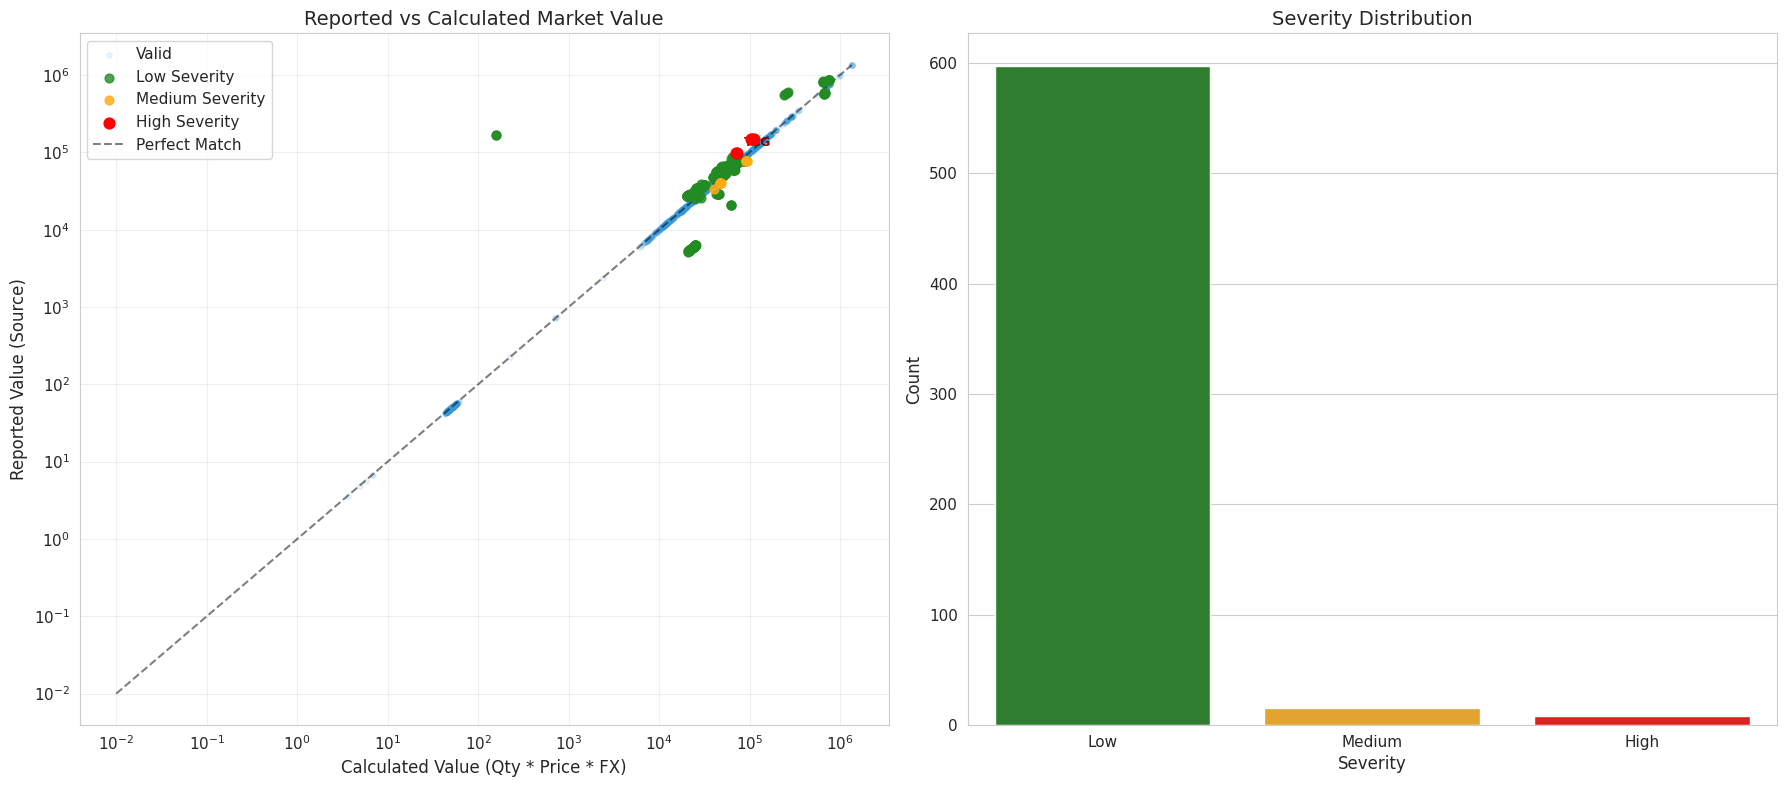

In [8]:
# --- 3.2 Visualization: Reported vs Calculated ---

if not calculation_errors_df.empty:
    # Prepare data for plotting
    calc_plot_df = positions.copy()
    cols = ["Close Quantity", "Price", "Exchange Rate", "Value in USD"]
    for col in cols:
        calc_plot_df[col] = pd.to_numeric(calc_plot_df[col], errors='coerce').fillna(0)
        
    calc_plot_df["Theoretical_Value"] = calc_plot_df["Close Quantity"] * calc_plot_df["Price"] * calc_plot_df["Exchange Rate"]
    
    ValidationVisualizer.plot_scatter_overview(
        df=calc_plot_df,
        x_col="Theoretical_Value",
        y_col="Value in USD",
        errors_df=calculation_errors_df,
        title="Reported vs Calculated Market Value",
        xlabel="Calculated Value (Qty * Price * FX)",
        ylabel="Reported Value (Source)",
        log_scale=True
    )

Visualizing top 3 tickers with High Severity Calculation errors.


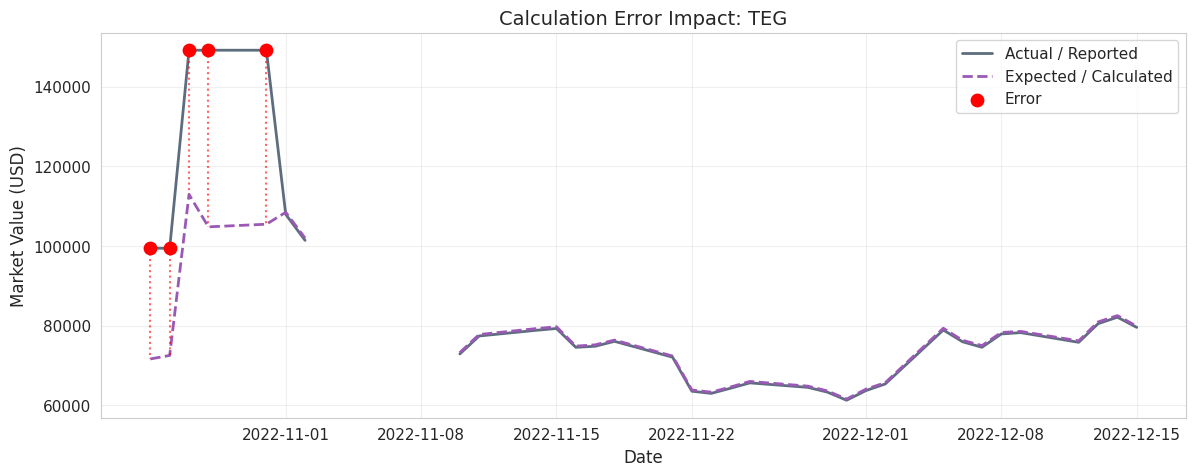

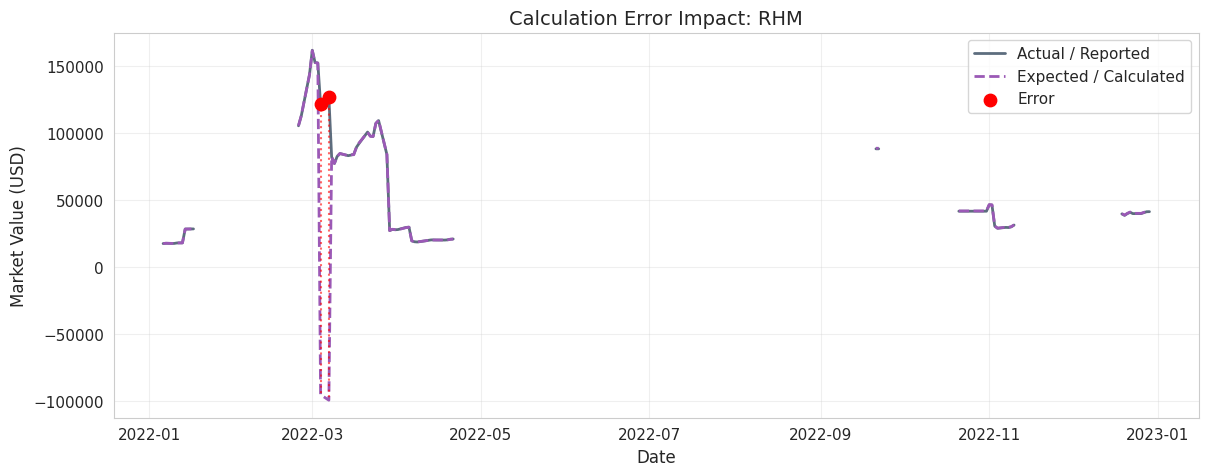

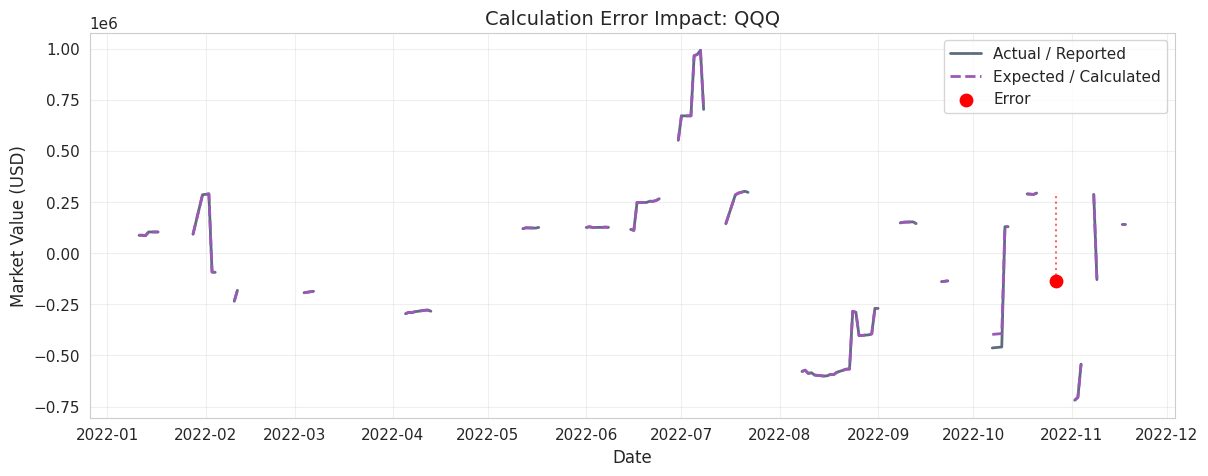

In [9]:
# --- 3.3 Deep Dive: High Severity Time Series ---

if not calculation_errors_df.empty:
    # Filter for High Severity errors
    calc_high = [e for e in calculation_errors if e.severity == 'High']
    
    if calc_high:
        # Count recurrence by ticker
        ticker_counts = {}
        for e in calc_high:
            ticker_counts[e.ticker] = ticker_counts.get(e.ticker, 0) + 1
            
        # Sort by recurrence (most frequent first)
        sorted_tickers = sorted(ticker_counts.items(), key=lambda x: x[1], reverse=True)
        top_tickers = [t[0] for t in sorted_tickers[:5]] # Top 5
        
        print(f"Visualizing top {len(top_tickers)} tickers with High Severity Calculation errors.")
        
        for ticker in top_tickers:
            # Prepare Ticker Data
            ticker_df = positions[positions['P_Ticker'] == ticker].copy()
            ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
            ticker_df = ticker_df.sort_values('Date')
            
            ticker_df['Reported'] = ticker_df['Value in USD'].apply(clean_float)
            ticker_df['Qty'] = ticker_df['Close Quantity'].apply(clean_float)
            ticker_df['Px'] = ticker_df['Price'].apply(clean_float)
            ticker_df['Fx'] = ticker_df['Exchange Rate'].apply(clean_float)
            ticker_df['Calculated'] = ticker_df['Qty'] * ticker_df['Px'] * ticker_df['Fx']
            
            # Get error dates
            error_dates = [e.date for e in calc_high if e.ticker == ticker]
            
            ValidationVisualizer.plot_time_series(
                ticker_df=ticker_df,
                date_col='Date',
                actual_col='Reported',
                expected_col='Calculated',
                error_dates=error_dates,
                title=f"Calculation Error Impact: {ticker}",
                ylabel="Market Value (USD)"
            )
    else:
        print("No High Severity Calculation errors found.")

### Systematic Discrepancy Analysis
We have identified that some tickers have consistent, systematic discrepancies (e.g., missing a constant multiplier or currency conversion). These have been downgraded to "Low" severity to separate them from genuine data glitches.

Below, we visualize these systematic errors to confirm they follow the same trend as the reported value, just offset by a factor.

Found 385 Systematic errors across 21 tickers.
Top systematic issues: ['PLUS', 'ANTO', '2GB']

Visualizing Systematic Error Example: PLUS


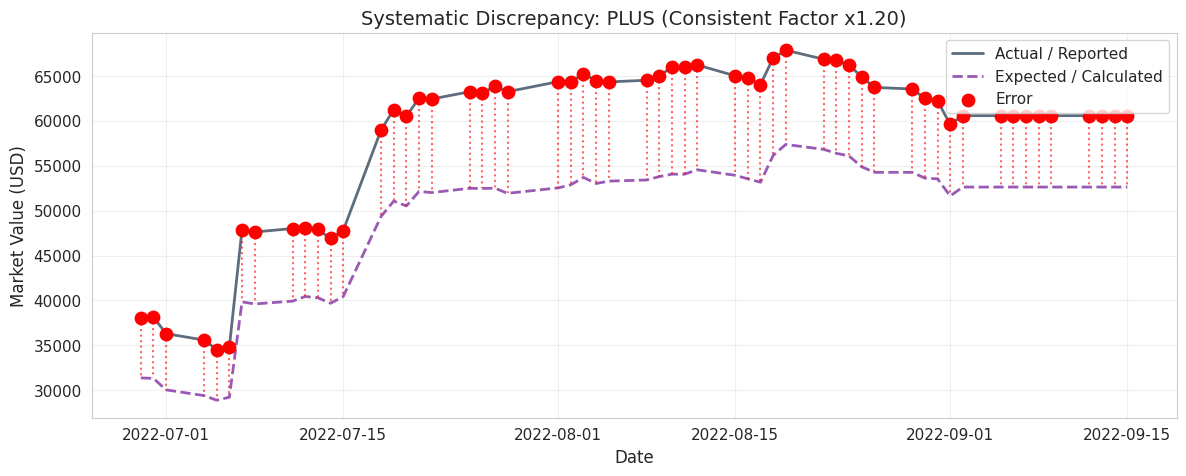

In [10]:
# --- 3.4 Systematic Discrepancy Analysis ---

# Filter for Systematic Errors
systematic_errors = [e for e in calculation_errors if "Systematic Multiplier" in e.description]

if systematic_errors:
    # Count recurrence
    sys_counts = {}
    for e in systematic_errors:
        sys_counts[e.ticker] = sys_counts.get(e.ticker, 0) + 1
        
    sorted_sys = sorted(sys_counts.items(), key=lambda x: x[1], reverse=True)
    top_sys = [t[0] for t in sorted_sys[:3]]
    
    print(f"Found {len(systematic_errors)} Systematic errors across {len(sys_counts)} tickers.")
    print(f"Top systematic issues: {top_sys}")
    
    if top_sys:
        example_ticker = top_sys[0]
        print(f"\nVisualizing Systematic Error Example: {example_ticker}")
        
        ticker_df = positions[positions['P_Ticker'] == example_ticker].copy()
        ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
        ticker_df = ticker_df.sort_values('Date')
        
        ticker_df['Reported'] = ticker_df['Value in USD'].apply(clean_float)
        ticker_df['Qty'] = ticker_df['Close Quantity'].apply(clean_float)
        ticker_df['Px'] = ticker_df['Price'].apply(clean_float)
        ticker_df['Fx'] = ticker_df['Exchange Rate'].apply(clean_float)
        ticker_df['Calculated'] = ticker_df['Qty'] * ticker_df['Px'] * ticker_df['Fx']
        
        # Extract multiplier
        example_error = next(e for e in systematic_errors if e.ticker == example_ticker)
        import re
        match = re.search(r"x([\d\.]+)", example_error.description)
        mult = match.group(1) if match else "?"
        
        # Get error dates
        error_dates = [e.date for e in systematic_errors if e.ticker == example_ticker]
        
        ValidationVisualizer.plot_time_series(
            ticker_df=ticker_df,
            date_col='Date',
            actual_col='Reported',
            expected_col='Calculated',
            error_dates=error_dates,
            title=f"Systematic Discrepancy: {example_ticker} (Consistent Factor x{mult})",
            ylabel="Market Value (USD)"
        )
else:
    print("No Systematic errors found.")

### Observations
*   **Systematic Errors**: A significant portion of the errors are **systematic**, meaning the reported value is consistently off by a factor (e.g., x100). This strongly suggests a unit mismatch (e.g., reporting in Cents vs Dollars, or Pence vs Pounds) or a missing contract multiplier.
*   **Random Errors**: The scatter plot shows some high-severity outliers that do not fit a systematic pattern, indicating potential data corruption or stale prices for those specific records.

## 4. Consistency Validation

### Methodology & Assumptions
We check for consistency between the **Trade Price** (execution price) and the **Market Price** (reported closing price) for the same day.

*   **Assumption**: While execution prices vary intra-day, they should generally be within a reasonable range of the day's closing price.
*   **Methodology**:
    1.  Calculates the **Percentage Difference** between Trade Price and Market Price.
    2.  Computes **Z-Scores** to identify statistical outliers relative to the asset's typical spread.
    3.  **Severity Logic**:
        *   **High**: Deviation > 20% or (Z > 5 and Deviation > 5%).
        *   **Medium**: Deviation > 10%.
        *   **Low**: Minor deviations (> 5%).

In [11]:
# --- 4.1 Execution ---
validator = ConsistencyValidator(positions, trades)
consistency_errors = validator.validate()

print(f"Found {len(consistency_errors)} consistency errors.")
if consistency_errors:
    consistency_errors_df = pd.DataFrame([vars(e) for e in consistency_errors])
    display(consistency_errors_df.head())
else:
    consistency_errors_df = pd.DataFrame()
    print("No consistency errors found.")

Found 27 consistency errors.


,date,ticker,error_type,description,severity
0,2022-02-07,RIVN,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 62.79 vs Market Pr...,Low
1,2022-02-28,DQ,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 44.90 vs Market Pr...,Low
2,2022-03-09,KAP,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 32.84 vs Market Pr...,High
3,2022-03-11,BNTX,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 144.75 vs Market P...,Low
4,2022-03-16,BNTX,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 152.09 vs Market P...,Low


/tmp/ipykernel_225859/219147499.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, order=order, palette=PALETTE, ax=ax)


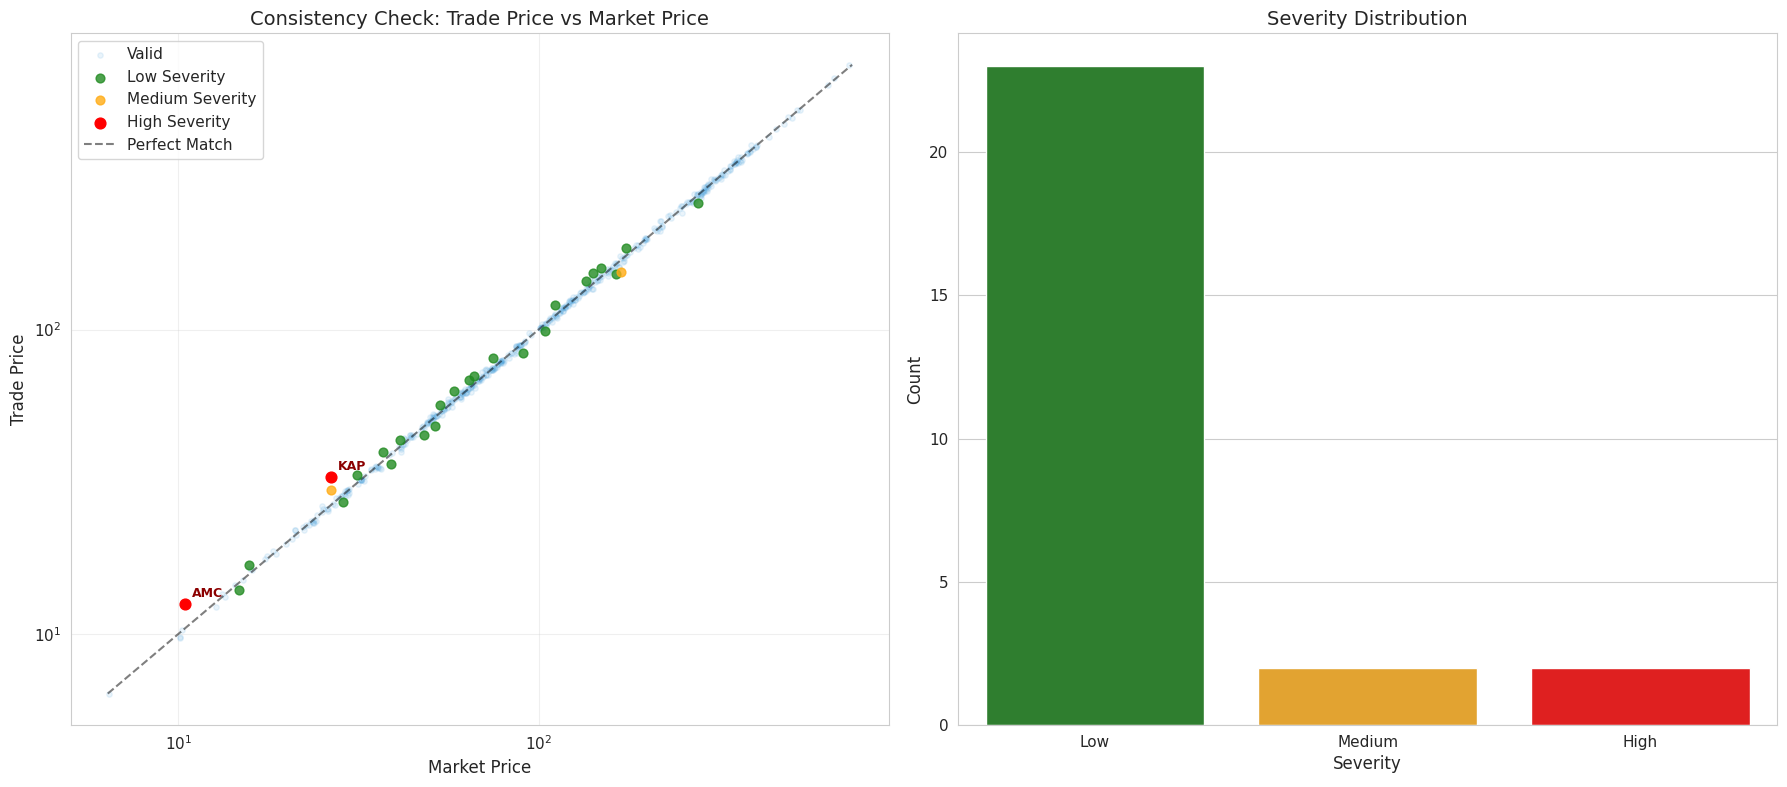

In [12]:
# --- 4.2 Visualization: Trade Price vs Market Price ---

if not consistency_errors_df.empty:
    # Prepare data for plotting
    cons_plot_df = positions.copy()
    cols = ["Price", "Trade Price", "Traded Today"]
    for col in cols:
        cons_plot_df[col] = pd.to_numeric(cons_plot_df[col], errors='coerce')
        
    # Filter for days with trades
    cons_plot_df = cons_plot_df[cons_plot_df["Traded Today"].abs() > 0].copy()
    cons_plot_df = cons_plot_df.dropna(subset=["Price", "Trade Price"])
    
    ValidationVisualizer.plot_scatter_overview(
        df=cons_plot_df,
        x_col="Price",
        y_col="Trade Price",
        errors_df=consistency_errors_df,
        title="Consistency Check: Trade Price vs Market Price",
        xlabel="Market Price",
        ylabel="Trade Price",
        log_scale=True
    )

Visualizing 2 tickers with High Severity consistency errors.


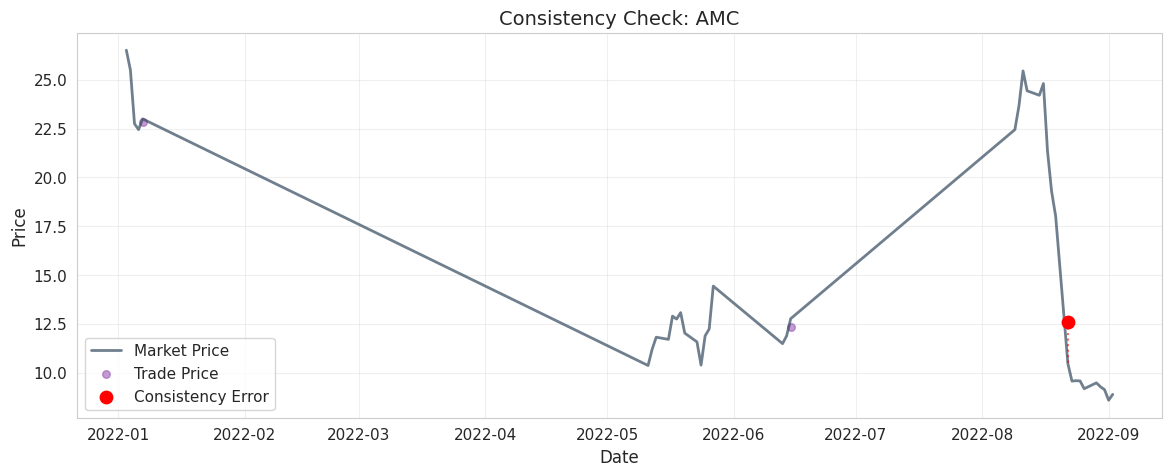

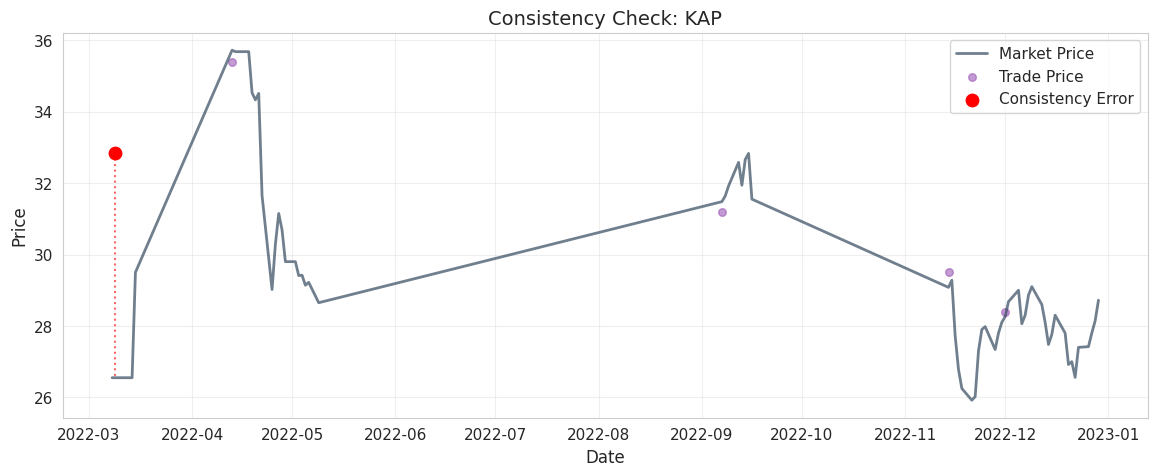

In [13]:
# --- 4.3 Deep Dive: High Severity Time Series ---

if not consistency_errors_df.empty:
    # Filter for High Severity
    high_severity_errors = [e for e in consistency_errors if e.severity == 'High']
    
    if high_severity_errors:
        error_tickers = list(set(e.ticker for e in high_severity_errors))
        print(f"Visualizing {len(error_tickers)} tickers with High Severity consistency errors.")
        
        for ticker in error_tickers:
            # Prepare data
            ticker_df = positions[positions['P_Ticker'] == ticker].copy()
            ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
            ticker_df = ticker_df.sort_values('Date')
            
            ticker_df['Price'] = pd.to_numeric(ticker_df['Price'], errors='coerce')
            ticker_df['Trade Price'] = pd.to_numeric(ticker_df['Trade Price'], errors='coerce')
            ticker_df['Traded Today'] = pd.to_numeric(ticker_df['Traded Today'], errors='coerce').fillna(0)
            
            # Plot
            plt.figure(figsize=(14, 5))
            
            # Market Price Line
            plt.plot(ticker_df['Date'], ticker_df['Price'], 
                    label='Market Price', color=PALETTE['Actual'], linewidth=2, alpha=0.7)
            
            # Trade Price Scatter
            trades_only = ticker_df[ticker_df['Traded Today'].abs() > 0]
            plt.scatter(trades_only['Date'], trades_only['Trade Price'], 
                       label='Trade Price', color=PALETTE['Expected'], marker='o', s=30, alpha=0.6)
            
            # Highlight Errors
            error_dates = [e.date for e in high_severity_errors if e.ticker == ticker]
            error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
            
            if not error_points.empty:
                plt.scatter(error_points['Date'], error_points['Trade Price'], 
                           color=PALETTE['High'], s=80, zorder=5, label='Consistency Error')
                
                for _, row in error_points.iterrows():
                    plt.plot([row['Date'], row['Date']], [row['Trade Price'], row['Price']], 
                             color=PALETTE['High'], linestyle=':', linewidth=1.5, alpha=0.6)

            plt.title(f"Consistency Check: {ticker}")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    else:
        print("No High Severity consistency errors found.")

### Observations
*   **Price Discrepancies**: The scatter plot highlights days where the execution price significantly diverged from the market close.
*   **Outlier Detection**: The Z-Score distribution helps distinguish between normal market volatility and genuine data errors.
*   **Severity**: High severity errors (red) indicate potential trade booking errors or stale market data feeds.

## 5. Data Completeness Validation

### Methodology & Assumptions
We ensure that the dataset contains all necessary fields for downstream calculations and reporting.

*   **Assumption**: A valid trade record must have a Ticker, Date, Price, Quantity, and Currency.
*   **Methodology**:
    1.  **Missing Value Check**: Scans for `NaN` or `None` values in critical columns (`P_Ticker`, `Date`, `Price`, `Exchange Rate`, `Close Quantity`, `Currency`).
    2.  **Zero Value Check**: Flags invalid zero values in fields where 0 is not possible (e.g., `Price`, `Exchange Rate`).
    3.  **Severity Logic**:
        *   **Medium**: Missing critical data (Price, Ticker, Date) is treated as a blocking issue for that record.
        *   **Low**: Missing non-critical descriptive fields.

Found 584 completeness errors.


,date,ticker,error_type,description,severity
0,2022-01-04,ADBE,Missing Data,Missing value for critical column: 'Close Quan...,Medium
1,2022-01-04,ADI,Missing Data,Missing value for critical column: 'Close Quan...,Medium
2,2022-01-04,NFLX,Missing Data,Missing value for critical column: 'Close Quan...,Medium
3,2022-01-04,NUE,Missing Data,Missing value for critical column: 'Close Quan...,Medium
4,2022-01-04,PLZL,Missing Data,Missing value for critical column: 'Close Quan...,Medium


Missing Data Distribution:


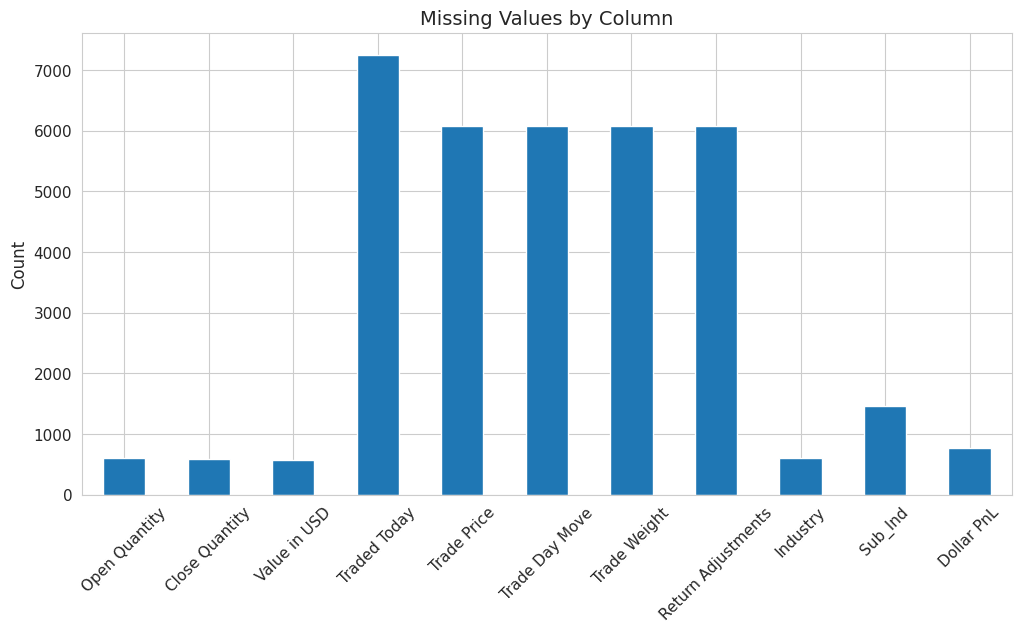

In [14]:
validator = DataCompletenessValidator(positions, trades)
completeness_errors = validator.validate()

print(f"Found {len(completeness_errors)} completeness errors.")
if completeness_errors:
    completeness_errors_df = pd.DataFrame([vars(e) for e in completeness_errors])
    display(completeness_errors_df.head())
    
    # Visualize Missing Data by Column
    print("Missing Data Distribution:")
    missing_counts = positions.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    
    if not missing_counts.empty:
        plt.figure(figsize=(12, 6))
        missing_counts.plot(kind='bar')
        plt.title("Missing Values by Column")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
else:
    completeness_errors_df = pd.DataFrame()

### Observations
*   **Missing Data**: The bar chart identifies which specific fields are most frequently missing (e.g., Ticker, Price).
*   **Impact**: Missing critical fields like 'Price' or 'Date' prevent further validation checks (Calculation, Consistency) from running on those records.
*   **Data Quality**: A high volume of missing data suggests upstream feed issues or incomplete data loading.

## 6. FX Consistency Validation

### Methodology & Assumptions
We verify that the same exchange rate is applied consistently across all assets denominated in the same currency for a given day.

*   **Assumption**: There should be a single, unified exchange rate for a specific currency on any given date (e.g., all USD assets use the same USD/GBP rate).
*   **Methodology**:
    1.  Groups the portfolio by **Date** and **Currency**.
    2.  Identifies the **Consensus Rate** (the most frequent rate, or mode) for that group.
    3.  Flags any records where the **Exchange Rate** deviates from this consensus.
    4.  **Severity Logic**:
        *   **High**: Deviation > 1% from the daily consensus.
        *   **Medium**: Minor deviations (<= 1%).

In [15]:
validator = FXConsistencyValidator(positions, trades)
fx_errors = validator.validate()

print(f"Found {len(fx_errors)} FX errors.")
if fx_errors:
    fx_errors_df = pd.DataFrame([vars(e) for e in fx_errors])
    display(fx_errors_df.head())
else:
    fx_errors_df = pd.DataFrame()

Found 0 FX errors.


## 7. Static Data Validation

### Methodology & Assumptions
We verify that reference data (static fields) for each asset remains constant over time.

*   **Assumption**: An asset's fundamental properties (Currency, Country, Sector) should not change during the reporting period.
*   **Methodology**:
    1.  Groups the portfolio by **Ticker**.
    2.  Checks for multiple unique values in static fields: `Currency`, `Country`, `Sector`, `Industry`, `Short_Name`.
    3.  Identifies the **Consensus Value** (the most frequent value) for each field.
    4.  Flags any records where the static data deviates from this consensus.
    5.  **Severity Logic**:
        *   **High**: Change in **Currency** (indicates a fundamental data break).
        *   **Medium**: Change in **Sector**, **Industry**, or **Country**.
        *   **Low**: Change in **Short_Name** (could be a rebranding or minor text difference).

## 7. Static Data Validation

We check for invalid or missing static data, such as Ticker symbols and ISINs.

Found 169 static data errors.


,date,ticker,error_type,description,severity
0,2022-11-09,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
1,2022-11-10,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
2,2022-11-24,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
3,2022-12-07,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
4,2022-12-08,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium


Static Data Error Distribution:


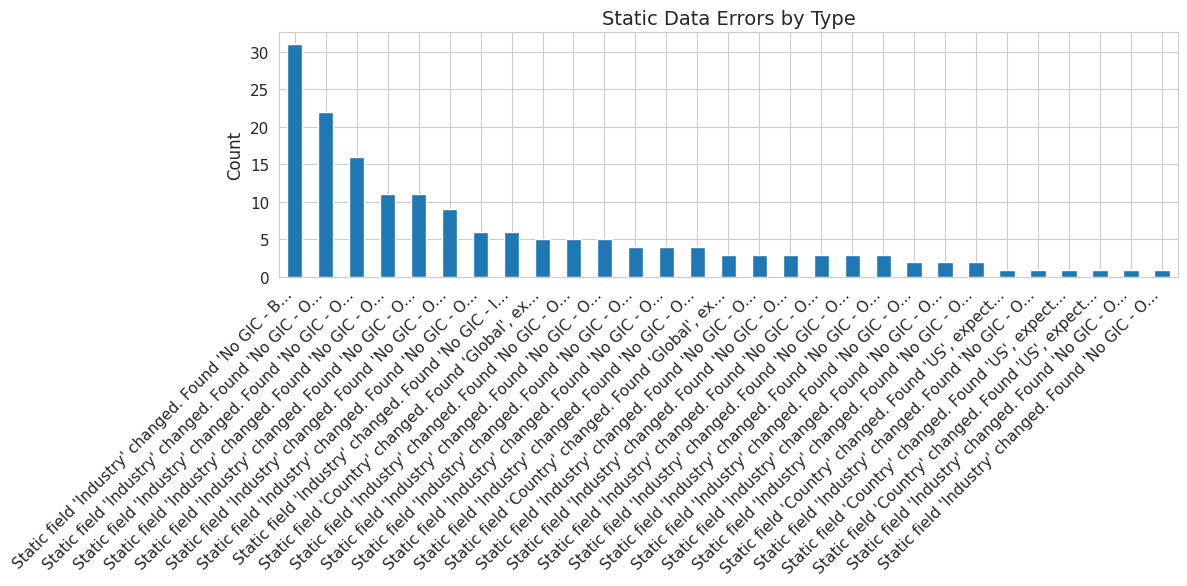

In [16]:
validator = StaticDataValidator(positions, trades)
static_errors = validator.validate()

print(f"Found {len(static_errors)} static data errors.")
if static_errors:
    static_errors_df = pd.DataFrame([vars(e) for e in static_errors])
    display(static_errors_df.head())
    
    # Visualize Static Data Errors
    print("Static Data Error Distribution:")
    # Group by error type or description to show what kind of static data issues exist
    error_counts = static_errors_df['description'].value_counts()
    
    if not error_counts.empty:
        # Truncate long descriptions for better visualization
        short_index = [desc[:50] + '...' if len(str(desc)) > 50 else str(desc) for desc in error_counts.index]
        error_counts.index = short_index  # type: ignore
        
        plt.figure(figsize=(12, 6))
        error_counts.plot(kind='bar')
        plt.title("Static Data Errors by Type")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    static_errors_df = pd.DataFrame()
    print("No static data errors found. All tickers and ISINs appear valid according to the validation rules.")

### Observations
*   **Stability**: Most static data is stable, but specific tickers show "flips" in fields like Sector or Country.
*   **Currency Flips**: Any High severity errors here (Currency changes) are critical as they affect all value-based calculations.
*   **Data Governance**: Frequent static data changes suggest a lack of master data management or issues with the reference data feed.

## 8. Aggregation & Conclusion
We aggregate all findings to identify the most problematic assets and the most common error types.

Total Errors Found: 1422


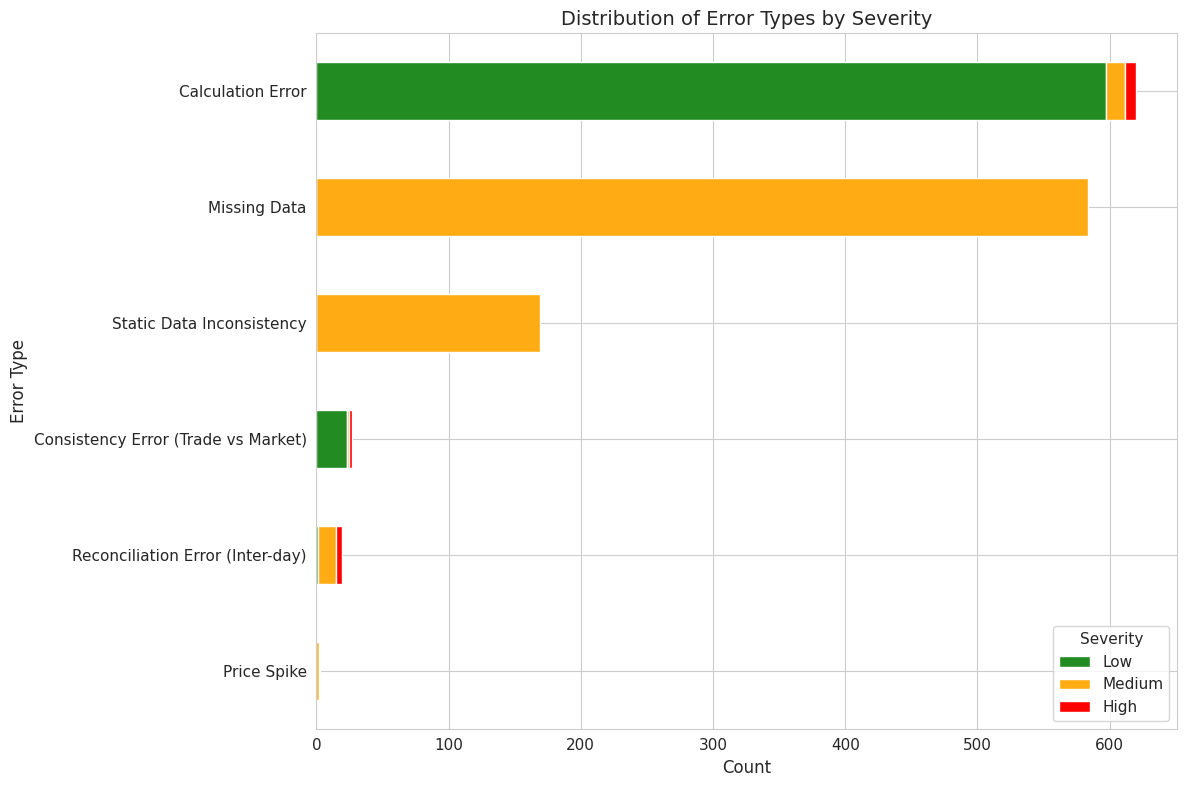


--- High Severity Errors Analysis (Action Items) ---
Found 15 High Severity Errors that require immediate attention.


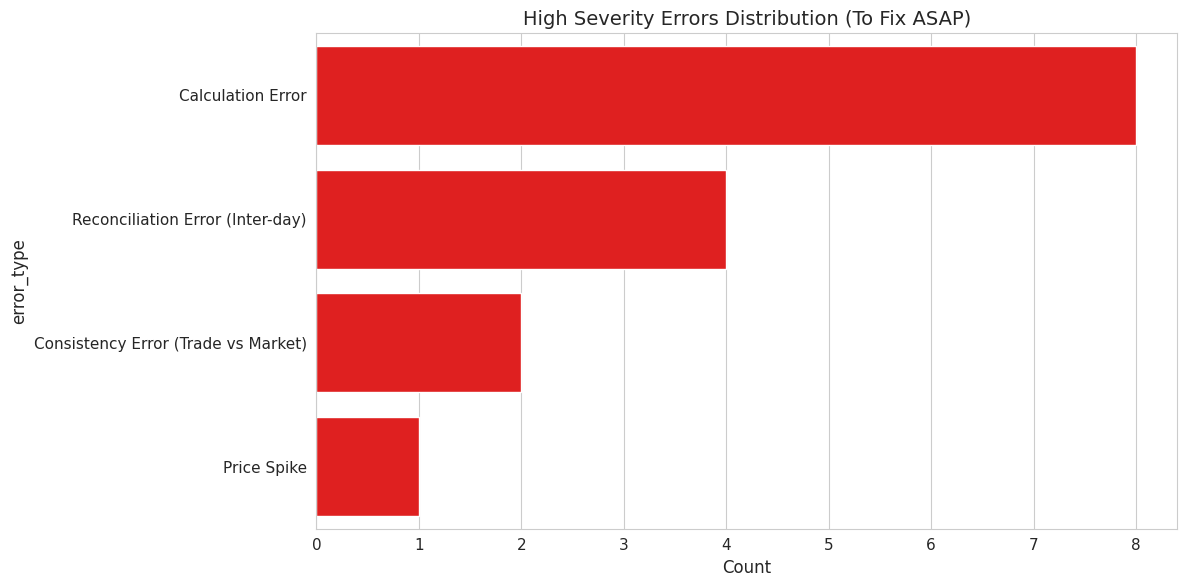

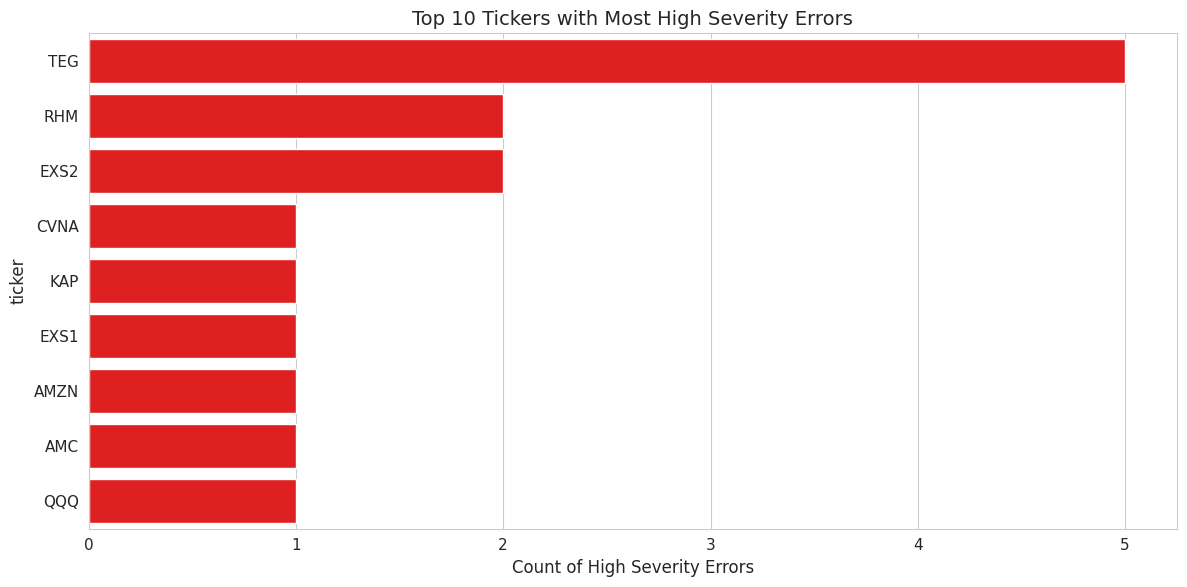

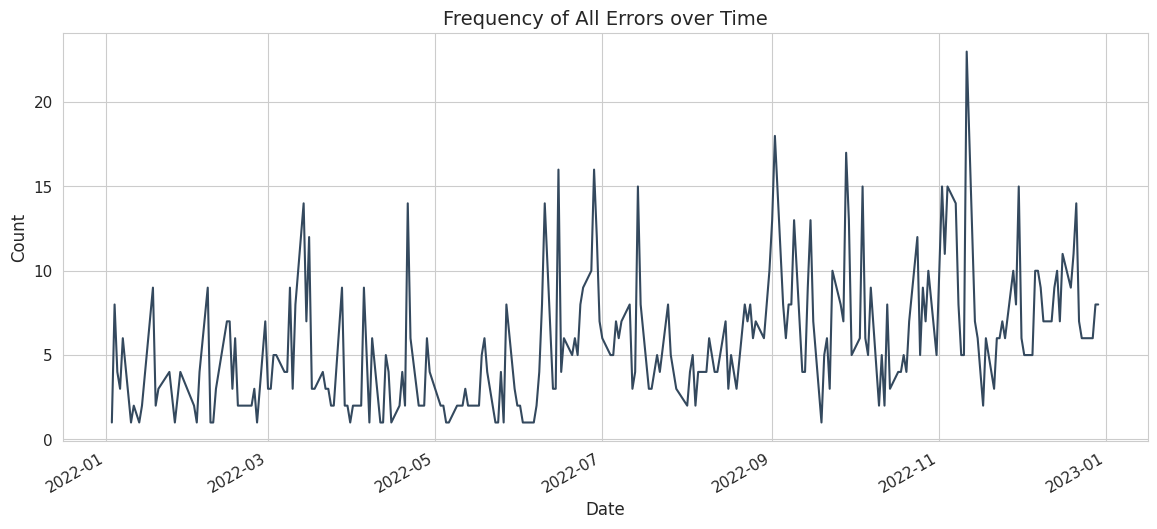


Summary of Errors by Ticker:


error_type,Calculation Error,Consistency Error (Trade vs Market),Missing Data,Price Spike,Reconciliation Error (Inter-day),Static Data Inconsistency,Total
ticker,,,,,,,
ANTO,60,0,6,0,0,3,69
XTB,64,0,1,0,0,0,65
PLUS,56,0,1,0,0,0,57
HAG,37,0,1,0,0,1,39
TGA,30,0,1,0,0,6,37
2GB,31,0,1,0,0,0,32
QQQ,3,0,27,0,2,0,32
EMHY,0,0,1,0,0,31,32
2561,30,0,1,0,0,0,31


In [17]:
# Aggregate all errors
all_errors_dfs = [
    completeness_errors_df,
    static_errors_df,
    price_errors_df,
    fx_errors_df,
    consistency_errors_df,
    reconciliation_errors_df,
    calculation_errors_df
]

# Filter out empty DataFrames
all_errors_dfs = [df for df in all_errors_dfs if not df.empty]

if all_errors_dfs:
    master_df = pd.concat(all_errors_dfs, ignore_index=True)
    print(f"Total Errors Found: {len(master_df)}")
    
    # --- 1. Error Types with Severity Breakdown (Stacked Bar Chart) ---
    severity_breakdown = master_df.groupby(['error_type', 'severity']).size().unstack(fill_value=0)
    
    # Reorder columns
    desired_order = ['Low', 'Medium', 'High']
    cols = [c for c in desired_order if c in severity_breakdown.columns]
    severity_breakdown = severity_breakdown[cols]
    
    # Sort by total
    severity_breakdown['Total'] = severity_breakdown.sum(axis=1)
    severity_breakdown = severity_breakdown.sort_values('Total', ascending=True)
    severity_breakdown = severity_breakdown.drop(columns=['Total'])
    
    # Plot Stacked Bar Chart
    colors = [PALETTE[c] for c in cols]
    ax = severity_breakdown.plot(kind='barh', stacked=True, color=colors, figsize=(12, 8))
    plt.title("Distribution of Error Types by Severity")
    plt.xlabel("Count")
    plt.ylabel("Error Type")
    plt.legend(title='Severity', loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # --- 2. Focus on High Severity Errors ---
    high_severity = master_df[master_df['severity'] == 'High']
    
    if not high_severity.empty:
        print(f"\n--- High Severity Errors Analysis (Action Items) ---")
        print(f"Found {len(high_severity)} High Severity Errors that require immediate attention.")
        
        # Distribution of High Severity Errors by Type
        high_counts = high_severity['error_type'].value_counts()
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=high_counts.values, y=high_counts.index, color=PALETTE['High'])
        plt.title("High Severity Errors Distribution (To Fix ASAP)")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
        
        # Top Tickers with High Severity Errors
        top_high_tickers = high_severity['ticker'].value_counts().head(10)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=top_high_tickers.values, y=top_high_tickers.index, color=PALETTE['High'])
        plt.title("Top 10 Tickers with Most High Severity Errors")
        plt.xlabel("Count of High Severity Errors")
        plt.tight_layout()
        plt.show()
    else:
        print("No High Severity errors found.")
    
    # --- 3. Errors over Time ---
    master_df['Date'] = pd.to_datetime(master_df['date'])
    errors_by_date = master_df.groupby('Date').size()
    
    plt.figure(figsize=(14, 6))
    errors_by_date.plot(color=PALETTE['Actual'])
    plt.title("Frequency of All Errors over Time")
    plt.ylabel("Count")
    plt.show()
    
    # Display Summary Table
    print("\nSummary of Errors by Ticker:")
    summary = master_df.groupby(['ticker', 'error_type']).size().unstack(fill_value=0)
    summary['Total'] = summary.sum(axis=1)
    display(summary.sort_values('Total', ascending=False).head(10))
else:
    print("No errors found across all validators.")